# TP 2: Aymane El Firdoussi

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SequentialFeatureSelector
from scipy.stats import t
from scipy.stats import norm
# imports go here

In [13]:
fn1 = "Aymane"
ln1 = "El Firdoussi"
filename = "_".join(map(lambda s: s.strip().lower(),
                      ["SD-TSIA204_lab2", ln1, fn1])) + ".ipynb"


## Question 1: Preprocessing the data

### 1-a) Fixing the random seed to 0

In [14]:
# Setting the random seed to 0
random.seed(0)

# Therefore, we will always get the same random value if we compute: random.random()

### 1-b) Loading the data and printing means and standard deviations

In [15]:
# Loading the data:
data = pd.read_csv("meatspec.csv")

#printing the mean of each covariate
data.mean()

V1       2.808561
V2       2.811137
V3       2.813727
V4       2.816363
V5       2.819098
          ...    
V97      3.081070
V98      3.062290
V99      3.043548
V100     3.024895
fat     18.142326
Length: 101, dtype: float64

In [16]:
# Printing the standard deviation of each covariate:
data.std()

V1       0.410793
V2       0.413352
V3       0.415906
V4       0.418465
V5       0.421040
          ...    
V97      0.539730
V98      0.538586
V99      0.537108
V100     0.535354
fat     12.740297
Length: 101, dtype: float64

#### The data is not centered since the mean is different from 0, nor it is standardized since standard deviations are not equal to 1. And all our data is not normalized since the values are not between 0 and 1.

## 1-c) Separating the data into train and test sets 

In [17]:
# The import of train_test_split has been done in the first cell
X = data.drop(['fat'], axis=1)
y= data['fat']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# The import of standard scaler has been done as well in the first cell
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_scaled = scaler.fit_transform(y_train.to_numpy().reshape(-1,1))
y_test_scaled = scaler.transform(y_test.to_numpy().reshape(-1,1))

In [18]:
# test if data is correctly standardized or not:
X_train_scaled.std()
#y_test_scaled.shape

1.0

## 1-d) Fitting a regular OLS:
The regular OLS is given by: 
$$ \theta = (X^TX)^{-1}X^T Y$$
We don't need to fit the intercept since the data is centered.
We can also use the Linear Regression model from the sklean.linear_model library.

In [19]:
# Computing the regular OLS estimator:
model = LinearRegression(fit_intercept=False)

# We fit the model to the training set
reg = model.fit(X_train_scaled,y_train_scaled)

# Prediction phase (test phase)
y_pred = reg.predict(X_test_scaled)
y_pred.shape

(54, 1)

#### 1-e) Computing the $R^2$ coefficients :
The $R^2$ can be calculated as follows:
 $$ R^2 = 1 - \frac{\| \hat{Y} - Y \|}{\| Y - \bar{y}_n \mathbb{1}_n\|} $$

 Where $ \hat{Y} $ is the predicted vector using our model, and $\mathbb{1}_n$ is the mean of the test vector y_test_scaled.

In [20]:
# Computing the R^2 coefficient for this OLS
def R2(y, y_pred):
    Y_bar = np.mean(y)
    SSR = np.sum((y_pred - y) ** 2)
    SST = np.sum((y - Y_bar) ** 2)
    return 1 - SSR / SST
    
R2 = reg.score(X_train_scaled, y_train_scaled)

# Storing it into a dataframe
d = {'model': [1], 'R2': [R2]}
df_coef = pd.DataFrame(data=d).set_index('model')
df_coef

,R2
model,
1,0.996794


## Question 2: Forward variable selection

The OLS $\theta_n(Y,X_k) = \arg \min_{\theta \in \mathbb{R}} \| Y - \theta X_k\|^2 $ is given by: (differentiating and finding the zero of the derivative)
$$ \theta_n(Y,X_k) = (X_k^T X_k)^{-1}X_k^T Y$$ 

In [21]:
# Define the statistic
def T(Y,X,k,n): # Y is a column vector, whereas X is our matrix
    Xk = X[:,k].reshape(-1,1)
    reg = LinearRegression().fit(Xk,Y)
    teta_n = reg.coef_[0]
    # inverse of Gram matrix
    G_1 = np.linalg.inv(Xk.T @ Xk)
    s_n = np.sqrt(G_1[0,0])
    sigma_n = (1/np.sqrt(n-2)) * np.linalg.norm(Y - reg.predict(Xk), 2) 
    return teta_n / (s_n * sigma_n)

# Forward variable selection algorithm
def forward_var_selection(X,Y): # X is a matrix, Y column vector and A the set of all columns of X
    n = X.shape[0]
    p = X.shape[1]
    r = Y.copy() 
    S = {} # the set of ordered features that we will get at the end, here it is a dictionary
    p_values = [] # the list of p-values

    #define the set of features
    A = list(range(0, p))

    while len(A) > 0 : 
        # Computing tests for all features
        values = np.zeros(p)
       
        for i in A : # columns left in A
            values[i] = abs(T(r, X, i, n))
        
        k_max = np.argmax(values)
        # computing the p-value associated with the value max
        p_value = 2*(1 - norm.cdf(abs(values[k_max])))
        p_values.append(p_value)

        # Adding the feature the maximizes the test T to S
        X_max = X[:, k_max].reshape(-1, 1)
        reg = LinearRegression().fit(X_max, r)
        S[k_max] = values[k_max]
        r = r - reg.predict(X_max)
        del A[A.index(k_max)]
    
    return S, p_values
  

In [22]:
# Preparing the data to use in forward variable selection
S,p_values = forward_var_selection(X_train_scaled,y_train_scaled) # 40, 7, 39, 6

# Now since features of our dataset are written as V'number +1', then we do the following
def features(l):
    V = []
    for i in l:
        V.append('V' + str(i + 1))
    return V 

# DataFrame with features and p values
d = {'index':S.keys(), 'feature': features(S.keys()), 'p_value': p_values}
df_var_sel = pd.DataFrame(data=d).set_index('index')
df_var_sel.head()

,feature,p_value
index,,
40,V41,5.995204e-15
7,V8,4.598669e-02
39,V40,4.854235e-02
6,V7,4.913438e-02
41,V42,5.185556e-02


## Question 3

### 3-a) Applying the OLS to features that have p value smaller than 0.05

In [23]:
# Selecting features with p value smaller than 0.05
mask = (df_var_sel['p_value'] < 0.05)
selected = df_var_sel.loc[mask].index.to_list()
selected

[40, 7, 39, 6]

In [24]:
# Applying OLS
reg = LinearRegression().fit(X_train_scaled[:,selected], y_train_scaled)
y_pred2 = reg.predict(X_test_scaled[:,selected])

### 3-b) Computing the $R^2$ coefficient for this model  

In [25]:
# R2 coefficient using sklearn
R2 = reg.score(X_train_scaled[:,selected], y_train_scaled)
#new_row = pd.Series([2, R2], index=['model', 'p_value'])
df_coef.loc[2] = [R2]


In [26]:
df_coef

,R2
model,
1,0.996794
2,0.925687


## Question 4: Sequential Feature Selector

In [27]:
# Using the sequential feature selctor from sklearn.feature_selection
reg = LinearRegression()
sfs = SequentialFeatureSelector(reg, n_features_to_select = len(selected), direction = 'forward')
sfs.fit(X_train_scaled, y_train_scaled)

# Returning the selected features
selected_sfs = [i for i, x in enumerate(sfs.get_support()) if x == True]
selected_sfs

[19, 21, 40, 47]

### Observation:
We observe that the features selected by the SequentialFeatureSelector are not all the same as the ones chosen with the Forward Variable Selection algorithm. Which was expected since the stopping criterion is different in both methods. 
In fact, for the Forward Variable selection, the stopping criterion that we chose is the p value of the statistical test, which is not so accurate since we are using an asymptotical behaviour of the test, hence we need more data to be more accurate. Whereas the SequentialFeatureSelector compares the score for each possible feature addition or removal, and selects the one that results in the best improvement of the score.

### Computing the $R^2$ score for this new feature selection

In [28]:
# Applying OLS of new features
reg = LinearRegression().fit(X_train_scaled[:,selected_sfs], y_train_scaled)
y_pred3 = reg.predict(X_test_scaled[:,selected_sfs])

# R2 coefficient using sklearn
R2 = reg.score(X_train_scaled[:,selected_sfs], y_train_scaled)

# Adding the new value to the dataFrame df_coef
df_coef.loc[3] = [R2]

In [29]:
df_coef

,R2
model,
1,0.996794
2,0.925687
3,0.955088


## Observation
We observe that the $R^2$ score for both methods are so close, and that they have similar performance.

## Ridge

## Question 5

The Ridge estimator is the solution of the following optimization problem:
$$ \hat{\theta}_n = \arg \min_{\theta \in \mathbb{R}^p} \| Y - X\theta\|^2 + \alpha \| \theta \|^2 $$
The function to minimize is $ \alpha $-strongly convex, hence the solution to this problem is unique and is given by:
$$ \hat{\theta}_n = (X^T X + \alpha I_p)^{-1} X^T Y$$
Where $X \in \mathbb{R}^{n x p}$ and $ Y \in \mathbb{R}^n $

In [41]:
# Programming the ridge estimator
def Ridge(X,Y,alpha):
    p = X.shape[1]
    return np.linalg.inv( X.T @ X + alpha* np.eye(p)) @ X.T @ Y

### 5 - (a)

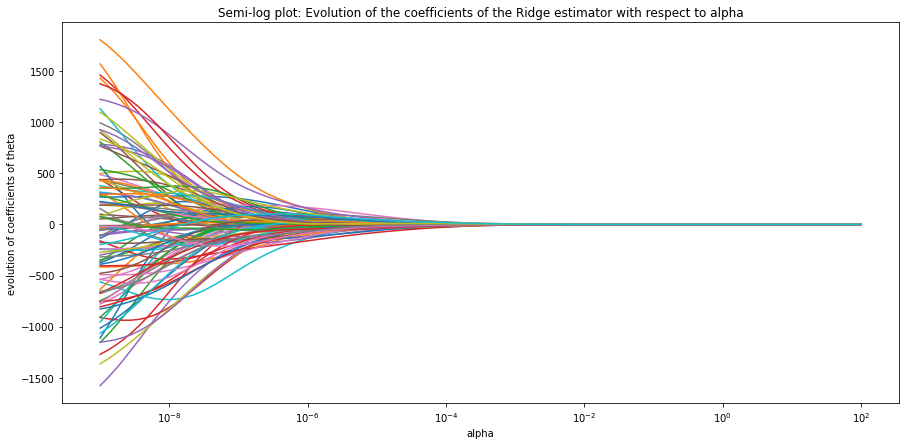

In [76]:
# Set of values of alpha
alpha_interval = np.logspace(np.log10(1e-9), np.log10(100), num=100)

# Computing the ridge estimators for each alpha and storing results in a list called estimators
estimators = Ridge(X_train_scaled, y_train_scaled, alpha_interval[0])

for alpha in alpha_interval[1:]:
    estimators = np.hstack((estimators,Ridge(X_train_scaled, y_train_scaled, alpha)))

# Plotting the evolution
plt.figure(figsize=(15,7))
for i in range(len(estimators)):
    plt.semilogx(alpha_interval, estimators[i])
plt.xlabel("alpha")
plt.ylabel("evolution of coefficients of theta")
plt.title("Semi-log plot: Evolution of the coefficients of the Ridge estimator with respect to alpha")
plt.show()

### Observation:
We observe that the Ridge estimator goes to zero when $\alpha$ is high. Which was expected since if $\alpha$ becomes large enough, we have that $\forall \theta \in \mathbb{R}^p$ : $$ \alpha \| \theta \|^2 + \| X\theta \|^2 \geq 2 \langle Y, X\theta \rangle $$ 
Hence, in that case: 0 is the unique solution to the problem.


### 5 - (b)